# Packages

In [24]:
import tensorflow as tf
import numpy as np
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
import random
from tensorflow import keras
from tensorflow.keras import layers
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from shutil import copyfile
import os
from data_aug.data_aug import *
from data_aug.bbox_util import *

In [25]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [26]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Parameters

In [27]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = "/home/pan/dl_py3/pan/comp2/pascal_voc_training_data.txt"
IMAGE_DIR = "/home/pan/dl_py3/pan/comp2/VOCdevkit_train/VOC2007/JPEGImages/"

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-5
EPOCHS = 200

# Data preprocess and augmentation

1. Preprocess

本組以ResNet152模型作為Pretrain model，因此圖片需經由預處理後才能使用，圖片預處理有分為caffe、ft、torch三種，其中VGG16、VGG19、ResNet屬於 caffe，而Xception屬於tf。caffe會將圖像從RGB轉換為BGR，然後將每個顏色通道相對於ImageNet數據集做中心化，即為減去ImageNet平均BGR(103.939,116.779,123.68)，最後再將圖片調整為(448,448)。

2. Augmentation
* 在本次競賽的資料PASCAL VOC2007中，資料含有20種類別，5012張照片。其中包含了12608個具有標記的物件(Object)。但是我們發現在這個資料集裡，可見下表，物件的數量極不平衡並且有些類別的數量過少，可能會有overfitting的情況發生或是使模型都預測在training data中最多的類別。

|  Classes  	|  0  	| 1   	|  2  	|  3  	| 4   	| 5   	| 6    	| 7   	| 8    	| 9   	| 10  	| 11  	| 12  	| 13  	| 14   	| 15  	| 16  	| 17  	| 18  	| 19  	|
|:-------:	|:---:	|-----	|:---:	|:---:	|-----	|-----	|------	|-----	|------	|-----	|-----	|-----	|-----	|-----	|------	|-----	|-----	|-----	|-----	|-----	|
| numbers 	| 331 	| 412 	| 577 	| 398 	| 612 	| 271 	| 1634 	| 389 	| 1423 	| 356 	| 309 	| 536 	| 403 	| 387 	| 5318 	| 603 	| 353 	| 419 	| 328 	| 366 	|

* 因此我們使用Data augmentation 的方式將圖片資料增加；除了增加資料外，亦可以透過此方式來平衡物件的數量。Data augmentation可以使現有的資料透過隨機翻轉、旋轉或是改變顏色等等。使得圖片的各種面向都可以被模型學習到，以減少在資料量較小時有overfitting的情形。

* 本組透過將圖片隨機改變其HSV(即為 Hue, Saturation, Lightness)、做剪力旋轉(shear, range(-0.15%,0.15%))與縮放(Rescale, range(-0.15%,0.15%))。來達成augmentation之目的。並且非對於所有的圖片皆進行。若該物件如：人類、車子與椅子，在資料中已經存在大量，將不會再增加圖片數量。若物件數量過少我們則產生20~10張的augmentation圖片，來平衡物件數差距過大之問題。

In [28]:
image_names = []
record_list = []
object_num_list = []
# filling the record_list
input_file = open(DATA_PATH, 'r')

for line in input_file:
    line = line.strip()
    ss = line.split(' ')
    image_names.append(ss[0])

    record_list.append([float(num) for num in ss[1:]])

    object_num_list.append(min(len(record_list[-1])//5, MAX_OBJECTS_PER_IMAGE))
    if len(record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
        record_list[-1] = record_list[-1] +\
        [0., 0., 0., 0., 0.]*\
        (MAX_OBJECTS_PER_IMAGE-len(record_list[-1])//5)
    elif len(record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
        record_list[-1] = record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]
        
# 更新bounding變成我們要的形式 
def update_bboxes(bbox):

    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]
    label = bbox[4]
    
    return [xmin,ymax,xmax,ymin,label]
    
# 判斷object是什麼
    
object_class = []
for i in range(len(record_list)):
    object_class2 = []
    k = 4
    for j in range(object_num_list[i]):
        object_class2.append(str(int(record_list[i][k])))
        k += 5
    object_class.append(object_class2)
    

# 得到bounding box
bboxes_list_raw = []
for i in range(len(record_list)):
    count = 0
    bboxes = []
    for j in range(int(len(record_list[i])/5)):
        bboxes.append(record_list[i][count:count + 5])
        count += 5
    bboxes = np.array([update_bboxes(k) for k in bboxes])
    bboxes_list_raw.append(bboxes)

bboxes_list_raw = dict(zip(image_names,bboxes_list_raw))


In [29]:
# 判斷是否要 data augmentation
def counter_for_10(object_list):
    object_strongaug_aug = sum([(i == '10') for i in object_list]) > 0
    object_no_aug = sum([(i == '6' or i == '8' or i == '14') for i in object_list]) > 1
    if object_strongaug_aug and not object_no_aug:
      return  True
    else:
      return False

def counter_for_special(object_list):
    object_strongaug_aug = sum([(i == '1' or i == '10' or i == '12' or i == '13' or i == '5') for i in object_list]) > 0
    object_no_aug = sum([(i == '6' or i == '8' or i == '14') for i in object_list]) > 0
    if object_strongaug_aug and not object_no_aug:
      return  True
    else:
      return False

def counter_element_strong(object_list):
    # 8,6物件(有不需要aug的)
    object_no_aug = sum([(i == '8' or i == '6' or i == '14') for i in object_list]) > 0
    if object_no_aug:
      return False
    else:
      return True

def counter_element(object_list):

    # 非14,非8,非6的物件(需要aug的為0)
    object_need_aug = sum([(i != '14' and  i != '8' and i != '6') for i in object_list]) == 0
    # 14,8,6物件(有不需要aug的)
    object_no_aug = sum([(i == '6' or i == '8' or i == '14') for i in object_list]) > 0
    # 14是否過多
    object_much_14 = sum([i == '14' for i in object_list]) > 0
    # 8是否過多
    #object_much_8 = sum([i == '8' for i in object_list]) > 1
    #object_10 = sum([i == '10' for i in object_list]) < 0

    if (object_need_aug and object_need_aug) or object_much_14:
        return False
    else:
        return True

# aug name
aug_names = []

for i in range(int(len(object_class))):
    if counter_for_10(object_class[i]):
        for j in range(20):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    elif counter_for_special(object_class[i]) == True:
        for j in range(15):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    elif counter_element_strong(object_class[i]) == True:
        for j in range(10):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    elif counter_element(object_class[i]) == True:
        for j in range(4):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    else:
        aug_names.append("aug" + "_" + '0' + "_" + image_names[i])

In [30]:
# Augmentation parameter

np.random.seed(77)
# HSV
H = np.random.randint(60,size = len(aug_names))
S = np.random.randint(60,size = len(aug_names))
V = np.random.randint(60,size = len(aug_names))

# HorizontalFlip
flip = np.random.binomial(1, 0.5, len(aug_names))
# Scale
scale1 = np.random.uniform(-0.15,0.15,len(aug_names))
scale2 = np.random.uniform(-0.15,0.15,len(aug_names))
# Shear
shear = np.random.uniform(-0.15,0.15,len(aug_names))


random_parameter = dict(zip(aug_names,list(zip(H,S,V,flip,scale1,scale2,shear))))


image_object_dict = dict(zip(image_names,object_num_list))

* Tensorflow dataset

In [31]:
# data generater(這樣寫不能平行運算，平行運算的版本可以看github上的)
def get_balance_augmentation():
    #count = 0
    for count in range(len(aug_names)):
        aug_name_list = aug_names[count].split('_')
        object_num = image_object_dict.get(aug_name_list[2])

        
        #若為０則生成原圖
        if aug_name_list[1] == "0":
            path = IMAGE_DIR +''+ aug_name_list[2]
            img_file = tf.io.read_file(path)
            img = tf.io.decode_jpeg(img_file, channels=3)
            bboxes = bboxes_list_raw.get(aug_name_list[2])
            
            count +=1
            
        # 否則生成變化圖
        else:
            parameter = random_parameter.get(aug_names[count])
            path = IMAGE_DIR +''+ aug_name_list[2]
            img_file = tf.io.read_file(path)
            img = tf.io.decode_jpeg(img_file, channels=3)
            
            bboxes = bboxes_list_raw.get(aug_name_list[2])
            seq = Sequence([RandomHSV((parameter[0],parameter[0]), (parameter[1],parameter[1]), (parameter[2],parameter[2])),
                            RandomHorizontalFlip(parameter[3]), Scale(parameter[4],parameter[5]), Shear(parameter[6])])
            img, bboxes = seq(img.numpy().copy(), bboxes.copy())
            
        if bboxes.shape[0] != 20:
            bboxes = np.concatenate([bboxes,np.zeros((20 - bboxes.shape[0] ,5))],axis = 0)
            
            count +=1
            
        # map function
        h = tf.shape(img)[0]
        w = tf.shape(img)[1]
        
        width_rate = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_rate = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 
        
        image = tf.image.resize(img, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.vgg16.preprocess_input(image) # 與vgg16的preprocess是相同的
        
        raw_labels = tf.cast(bboxes, tf.float32)
        
        # 為了不要讓bboxes的數值爆掉，皆對bboxes range做一個修正。
        xmin = raw_labels.numpy()[:, 0]
        xmin[xmin > w.numpy()] = w.numpy()
        
        ymax = raw_labels.numpy()[:, 1]
        ymax[ymax > h.numpy()] = h.numpy()
        
        xmax = raw_labels.numpy()[:, 2]
        xmax[xmax > w.numpy()] = w.numpy()
        
        ymin = raw_labels.numpy()[:, 3]
        ymin[ymin > h.numpy()] = h.numpy()
        
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_rate
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_rate

        box_w = (xmax - xmin) * width_rate
        box_h = (ymax - ymin) * height_rate
        
        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis = 1)
        
        # BBOXES做過濾，以免BBOXES超出邊界。
        if ((xcenter.numpy()[:object_num] > 447.5).sum() + (ycenter.numpy()[:object_num] > 447.5).sum()) > 0:
            continue   

        if ((box_w.numpy()[:object_num] < 0.5).sum() + (box_h.numpy()[:object_num] < 0.5).sum()) > 0:
            continue
            
        if np.any((xcenter - box_w/2) < 0):
            continue
        
        if np.any((ycenter - box_h/2) < 0):
            continue
        
        if np.any((xcenter + box_w/2) > 500):
            continue
        
        if np.any((ycenter + box_h/2) > 500):
            continue
        
        
    
        yield image, labels, tf.cast(object_num,tf.int32)

# Tensorflow dataset
dataset = tf.data.Dataset.from_generator(get_balance_augmentation,
                                         (tf.float32, tf.float32,tf.int32),
                                         (tf.TensorShape([448,448,3]),tf.TensorShape([20,5]),tf.TensorShape([])))
dataset = dataset.shuffle(2000)
dataset = dataset.batch(BATCH_SIZE)

* Demo the result of preprocess and augmentation

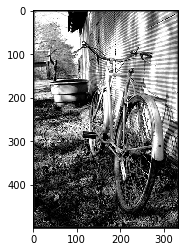

In [55]:
# Original image
img = cv2.imread("/home/pan/dl_py3/pan/comp2/VOCdevkit_train/VOC2007/JPEGImages/000016.jpg")[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
plt.imshow(img)
plt.show()

* After our preprocess and augmentation

In [50]:
data_generator = get_balance_augmentation()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


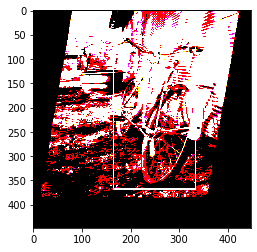

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


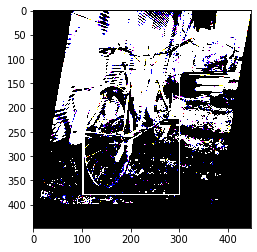

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [52]:
# VGG16 preprocess and data augmentation
for i in range(5):
    x,y,z = next(data_generator)

    label = y.numpy()[0:z.numpy(),:]
    min_x = (label[:,0] - (label[:,2] / 2))
    max_x = (label[:,0] + (label[:,2] / 2))
    min_y = (label[:,1] - (label[:,3] / 2))
    max_y = (label[:,1] + (label[:,3] / 2))
    yy = np.column_stack((min_x,max_y,max_x,min_y))
    plot_img = draw_rect(x.numpy()[:,:,:],yy)
    plt.imshow(plot_img)
    plt.show()


*　圖片被調整成(448,448)，顏色角度都會經過上述調整。
* 經過上述的調整所有圖片的物件明顯平衡許多。

|  Classes  	|   0  	| 1    	|   2  	|   3  	| 4    	| 5    	| 6    	| 7    	| 8    	| 9    	| 10   	| 11   	| 12   	| 13   	| 14   	| 15   	| 16   	| 17   	| 18   	| 19   	|
|:-------:	|:----:	|------	|:----:	|:----:	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|
| numbers 	| 2938 	| 1480 	| 5047 	| 3093 	| 2691 	| 1616 	| 2312 	| 3431 	| 3852 	| 2516 	| 1298 	| 3807 	| 1557 	| 1691 	| 5565 	| 4208 	| 3202 	| 2078 	| 2568 	| 1930 	|

# Model

* 本組在本次比賽修改自YOLO v1 model。使用pretrain model做特徵提取再修改底層並預測bounding box和 labels。

* 本組Pretrain model使用ResNet152模型，其中我們也嘗試過使用VGG16、VGG19、Xception model當作我們的pretrain，但是效果都不如ResNet152模型，因此最後我們選用ResNet152模型當作我們的Pretrain model且設定model.trainable=False，希望model的weight不要重train，而是利用原本在ImageNet數據集中訓練出來的weight，因為我們現在的照片數遠遠不比ImageNet數據集大，因此用ImageNet的Weight是在較大的資料集下所獲得，特徵提取的效果也會比較好。



In [7]:
pre_trained_model = tf.keras.applications.ResNet152(include_top=False, weights='imagenet',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
pre_trained_model.trainable=False



* 而接pretrain model底下的NN。本組參考Yolo原本的模型，但是只加上兩層1024 * 1024 Convolution2D layer。並且不做zero padding。本組嘗試後發現原本yolo 4層Convolution2D layer接在pretrain model後效果不佳，應使用較少層的layer，會讓準確率較高。而Regularizers.l2與Dropout使得我們在這些層的訓練不要overfitting。而疊層方式與參數設定皆經由try and error的方式比較其效果與回顧文獻所決定的。 

In [58]:
img_inputs = keras.models.Sequential()

img_inputs.add(layers.Conv2D(1024,3,strides=1,kernel_regularizer = tf.keras.regularizers.l2(0.0005)))
img_inputs.add(layers.LeakyReLU(0.1))
img_inputs.add(layers.Conv2D(1024,3,strides=2,kernel_regularizer = tf.keras.regularizers.l2(0.0005)))
img_inputs.add(layers.LeakyReLU(0.1))


img_inputs.add(layers.Flatten())
img_inputs.add(layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)))
img_inputs.add(layers.Dropout(0.5))
img_inputs.add(layers.Dense(1024, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)))
img_inputs.add(layers.LeakyReLU(0.1))
img_inputs.add(layers.Dense(CELL_SIZE*CELL_SIZE*(BOXES_PER_CELL*5+20),
                            activation='relu', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)))

YOLO = keras.Model(inputs=pre_trained_model.input, outputs=img_inputs(pre_trained_model.output), name="YOLO")

In [61]:
img_inputs.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 12, 12, 1024)      18875392  
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 12, 12, 1024)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 1024)        9438208   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 5, 5, 1024)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              104861696 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)             

In [9]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

#for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.tile(np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4]), [1, 1, BOXES_PER_CELL, 1])

* YOLO loss

In [10]:
def yolo_loss(predicts, labels, objects_num):
    """
    calculate loss
    Args:
        predict: 3-D tensor [cell_size, cell_size, 5 * boxes_per_cell]
        labels : [max_objects, 5]  (x_center, y_center, w, h, class)
    """
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    batch_size = predicts.shape[0]
    loss = 0.

    for i in tf.range(batch_size):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

* IOU

In [11]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #calculate objects tensor [CELL_SIZE, CELL_SIZE]
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)

    temp = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    objects = tf.ones(temp, tf.float32)

    temp = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    temp = tf.reshape(temp, (2, 2))
    objects = tf.pad(objects, temp, "CONSTANT")

    #calculate objects  tensor [CELL_SIZE, CELL_SIZE]
    #calculate responsible tensor [CELL_SIZE, CELL_SIZE]
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    temp = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                   tf.int32)
#     tmp = tf.stack([center_y, CELL_SIZE - center_y - 1,
#                     center_x, CELL_SIZE - center_x - 1])
    temp = tf.reshape(temp, (2, 2))
    response = tf.pad(response, temp, "CONSTANT")
    #objects = response

    #calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])

    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])
    #calculate C [cell_size, cell_size, boxes_per_cell]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    max_I = tf.reduce_max(I, 2, keepdims=True)

    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    #p_sqrt_w = tf.sqrt(tf.abs(predict_boxes[:, :, :, 2])) * ((tf.cast(predict_boxes[:, :, :, 2] > 0, tf.float32) * 2) - 1)
    #p_sqrt_h = tf.sqrt(tf.abs(predict_boxes[:, :, :, 3])) * ((tf.cast(predict_boxes[:, :, :, 3] > 0, tf.float32) * 2) - 1)
    #p_sqrt_w = tf.sqrt(tf.maximum(0.0, predict_boxes[:, :, :, 2]))
    #p_sqrt_h = tf.sqrt(tf.maximum(0.0, predict_boxes[:, :, :, 3]))
    #p_sqrt_w = predict_boxes[:, :, :, 2]
    #p_sqrt_h = predict_boxes[:, :, :, 3]
    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predict p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(objects, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE
    #class_loss = tf.nn.l2_loss(tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE
    #object_loss = tf.nn.l2_loss(I * (p_C - (C + 1.0)/2.0)) * OBJECT_SCALE

    #noobject_loss
    #noobject_loss = tf.nn.l2_loss(no_I * (p_C - C)) * NOOBJECT_SCALE
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                 tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                 tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                 tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

* SGD

In [12]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

* Checkpoint

In [99]:
CKT_Dir = './ckpts/AUG_RestNetYOLO'
checkpoint_name = 'yolo_v1_ResNet152_normal'

last_ckp = tf.train.latest_checkpoint(CKT_Dir)
if last_ckp:
    ckpt = tf.train.Checkpoint(net=YOLO)
    ckpt.restore(last_ckp)
    init_epoch = int(last_ckp.split("-")[-1])+1
    print(f'Resume training from epoch {init_epoch-1}')
else:
    init_epoch=1

Resume training from epoch 200


In [100]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(init_epoch-1), net=YOLO)

manager = tf.train.CheckpointManager(ckpt, CKT_Dir, max_to_keep=3,
                                     checkpoint_name=checkpoint_name)

In [15]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        n1 = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        n2 = n1 + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:n1], (-1, CELL_SIZE, CELL_SIZE, 20))
        scales = tf.reshape(outputs[:, n1:n2], (-1, CELL_SIZE, CELL_SIZE, 2))
        boxes = tf.reshape(outputs[:, n2:], (-1, CELL_SIZE, CELL_SIZE, 2*4))
        predicts = tf.concat([class_probs, scales, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

# Start training
*　本組設定Epoch數量為200個，但是礙於時間的考量與設備我們在比賽結束前只有做到163個。但是其實loss已經接近收斂。

In [ ]:
print("{}, start training.".format(datetime.now()))
for i in range(init_epoch,EPOCHS+1):
    print("Epoch: %d/%d" % (i,EPOCHS))
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        if idx % 1000 == 0:
            print(idx)
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i, train_loss_metric.result()))

    save_path = manager.save(checkpoint_number=tf.Variable(ckpt.epoch))
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

2019-12-07 00:48:19.360252, start training.
Epoch: 163/200


/home/pan/dl_py3/momo/Competition/2/data_aug/bbox_util.py:82: RuntimeWarning: invalid value encountered in true_divide
  delta_area = ((ar_ - bbox_area(bbox))/ar_)
/home/pan/dl_py3/momo/Competition/2/data_aug/bbox_util.py:84: RuntimeWarning: invalid value encountered in less
  mask = (delta_area < (1 - alpha)).astype(int)


0


/home/pan/dl_py3/momo/Competition/2/data_aug/bbox_util.py:82: RuntimeWarning: invalid value encountered in true_divide
  delta_area = ((ar_ - bbox_area(bbox))/ar_)
/home/pan/dl_py3/momo/Competition/2/data_aug/bbox_util.py:84: RuntimeWarning: invalid value encountered in less
  mask = (delta_area < (1 - alpha)).astype(int)


1000
2000


# Output files

* 從training image或是testing image可知一張圖片可能會有許多物件，因此我們希望在output file階段能將圖中所有物件框出來，而不是只考慮confidence最高的bounding box，我們知道yolo的建構下會將圖片切分成7X7格子(cell)，然後每個cell會預測屬於20個class的機率以及2個bounding box，而bounding box以(xcenter, ycenter, w, h, confidence)呈現， confidence代表框住的是否為物體的信心程度。

* 由上述可知這98個bounding box不是每個都要保留，需要一些機制將作用重疊以及沒有框住物體的box去除，因此我們設置score_threshold將confidence低於score_threshold的bounding box去除，即代表去除的bounding box有框到物體的機率較低，另外設置iou_threshold且透過與confidence高的bounding box做比較，將與其重疊面積大的bounding box(iou值大於iou_threshold)去除，以避免同一物件受許多的bounding box框住，故藉此機制挑選出有用的box，並output出來。

* 當中iou_threshold若設太高，可能會保留太多作用相同的bounding box，而score_threshold設太高可能會將所有bounding box去除，故在這情況下則退而選擇confidence最高的bounding box輸出，另外在調整過程中發現這兩個門檻的設置與模型表現有關，需要對應調整。

In [70]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    n1 = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    n2 = n1 + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:n1], (-1, CELL_SIZE, CELL_SIZE, 20))
    scales = np.reshape(outputs[:, n1:n2], (-1, CELL_SIZE, CELL_SIZE, 2))
    boxes = np.reshape(outputs[:, n2:], (-1, CELL_SIZE, CELL_SIZE, 2*4))
    predicts = np.concatenate([class_probs, scales, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]
    #print P[5,1, 0, :]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

In [69]:
import tensorflow.keras.backend as K
def process_outputs3(outputs,score_threshold,iou_threshold):
    """
    Process YOLO outputs into bou
    """
    n1 = CELL_SIZE * CELL_SIZE * NUM_CLASSES#7*7*20
    n2 = n1 + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL#7*7*2
    class_probs = np.reshape(outputs[:, 0:n1], (-1, 7, 7, 20))#每cell 20類機率
    scales = np.reshape(outputs[:, n1:n2], (-1, 7, 7, 2))
    boxes1 = np.reshape(outputs[:, n2:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, scales, boxes1], 3)
    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]
    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))#prob class
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))#confidence
    coordinate = np.reshape(coordinate,(CELL_SIZE,CELL_SIZE,BOXES_PER_CELL,4))#
    ######處理座標
    coord_x = tf.cast(tf.reshape(tf.tile(tf.range(CELL_SIZE), [CELL_SIZE]), ( CELL_SIZE, CELL_SIZE, 1, 1)), tf.float32)
    coord_y = tf.transpose(coord_x, (1,0,2,3))
    coords = tf.tile(tf.concat([coord_x,coord_y], -1), [ 1, 1, 2, 1])
    pred_xy=(coordinate[:,:,:,0:2]+coords)* (IMAGE_SIZE/float(CELL_SIZE))
    pred_wh = coordinate[:,:,:,2:4]* IMAGE_SIZE
    box_xy1 =pred_xy-0.5*pred_wh
    box_xy2 =pred_xy+0.5*pred_wh
    boxes=np.concatenate([box_xy1, box_xy2], axis=-1)
    ################    
    #######score
    P = C * p_classes#  class|confidence
    #P's shape [7, 7, 2, 20]
    #print P[5,1, 0, :]
    #choose the most confidence one
    box_classes = np.argmax(P, axis=-1)
    box_class_scores = np.max(P, axis=-1)
    prediction_mask = box_class_scores >= score_threshold
    boxes = tf.boolean_mask(boxes, prediction_mask)
    scores = tf.boolean_mask(box_class_scores, prediction_mask)
    classes = tf.boolean_mask(box_classes, prediction_mask)
    # Non Max Supression
    selected_idx = tf.image.non_max_suppression(boxes, scores, 50, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, selected_idx)
    scores = K.gather(scores, selected_idx)
    classes = K.gather(classes, selected_idx)
    return(boxes,classes,scores)
def set_bound(x):
    if (x>IMAGE_SIZE):
        return(IMAGE_SIZE)
    elif(x<0):
        return(0)
    else:
        return(x)

* Testing dataset

In [84]:
test_img_files = open('/home/pan/dl_py3/pan/comp2/pascal_voc_testing_data.txt')
test_img_dir = '/home/pan/dl_py3/pan/comp2/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_images = test_images
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]
    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.keras.applications.vgg16.preprocess_input(image)

    return image_name, image, h, w

In [85]:
test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32) 

* Read ckpt

In [101]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore(CKT_Dir+"/"+checkpoint_name+"-"+str(200))

* Output the result of prediction

In [81]:
@tf.function
def prediction_step(img):
    return YOLO(img)

In [86]:
output_file = open('./test_prediction.txt', 'w')
score = 0.0001
iou_threshold = 0.2
for i in range(16):
    print(i)
    #output_file = open('/content/drive/My Drive/new/pascal_voc_testing_data.txt', 'a+')
    for img_name, test_img, img_h, img_w in test_dataset.skip(i*500).take(500):
        batch_num = img_name.shape[0]
        for i in range(batch_num):
            boxes, classe,scores = process_outputs3(prediction_step(test_img[i:i+1]),score,iou_threshold)
            output = img_name[i:i+1].numpy()[0].decode('ascii')
            if len(boxes) == 0 :
               xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
               xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)                             #class取0可能不好
               output = output+" %d %d %d %d %d %f" %(xmin, ymin, xmax, ymax, class_num, conf)
            #model train不好的措施
            else:
                for j in range((len(boxes))):
                    xmin = set_bound(boxes[j,0])*tf.cast((img_w[i:i+1]/IMAGE_SIZE), dtype=tf.float32)
                    ymin = set_bound(boxes[j,1])*tf.cast((img_h[i:i+1]/IMAGE_SIZE), dtype=tf.float32)
                    xmax = set_bound(boxes[j,2])*tf.cast((img_w[i:i+1]/IMAGE_SIZE), dtype=tf.float32)
                    ymax = set_bound(boxes[j,3])*tf.cast((img_h[i:i+1]/IMAGE_SIZE), dtype=tf.float32)
                    output = output+" %d %d %d %d %d %f" %(xmin, ymin, xmax, ymax, classe[j], scores[j])
            #img filename, xmin, ymin, xmax, ymax, class, confidence
            output_file.write(output+'\n')
    #output_file.close()
output_file.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


# Result and Discussion

* 最後本組的模型在Testing data中，MPA = 0.51。



In [113]:
# Define a function to plot our prediction
def plot_result(path,score = 0.00001,iou_threshold = 0.2):
    np_img = cv2.imread(path)
    resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
    np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    resized_img = np_img
    np_img = np_img.astype(np.float32)
    np_img = tf.keras.applications.vgg16.preprocess_input(np_img)
    np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))
    y_pred = YOLO(np_img)
    score = 0.00001
    iou_threshold = 0.1
    boxes, classe,scores = process_outputs3(y_pred,score,iou_threshold)
    count_detected = boxes.shape[0]
    for i in range(count_detected):
        box = boxes[i,...]
        xmin = set_bound(box[0])
        ymin = set_bound(box[1])
        xmax = set_bound(box[2])
        ymax = set_bound(box[3])
        cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
        cv2.putText(resized_img, classes_name[classe[i]], (xmin, ymin), 2, 1.5, (0, 255, 255), 2)
    plt.imshow(resized_img)
    plt.show()

* 本組發現模型預測的圖片若具有僅具有**一個大並且明顯的物件**，則當Epoch達到收斂後；我們的模型可以將照片中的物件預測的非常精準，並且bunding box亦可以圈出物體，confidence高。如下列結果：

In [115]:
plot_result('/home/pan/dl_py3/pan/comp2/VOCdevkit_test/VOC2007/JPEGImages/000002.jpg')

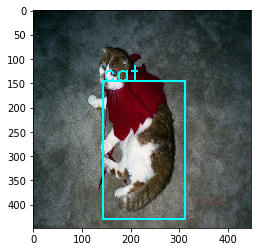

In [116]:
plot_result('/home/pan/dl_py3/pan/comp2/VOCdevkit_test/VOC2007/JPEGImages/000011.jpg')

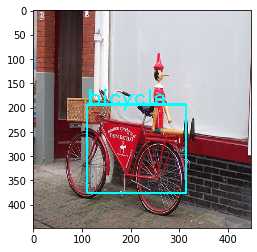

In [118]:
plot_result('/home/pan/dl_py3/pan/comp2/VOCdevkit_test/VOC2007/JPEGImages/000015.jpg')

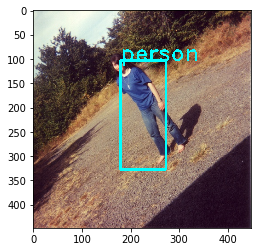

In [119]:
plot_result('/home/pan/dl_py3/pan/comp2/VOCdevkit_test/VOC2007/JPEGImages/000027.jpg')

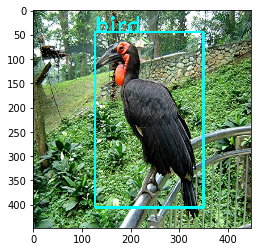

In [122]:
plot_result('/home/pan/dl_py3/pan/comp2/VOCdevkit_test/VOC2007/JPEGImages/000057.jpg')

*　但是若照片中的**物體較多或是物體較小**，模型的預測通常無法準確的框出多個bounding box，僅能預測出較大較明顯的物體，並且給予的confidence也都是偏低，就算能夠預測出物體通常也都是錯誤的。這是本組模型較大的缺點。

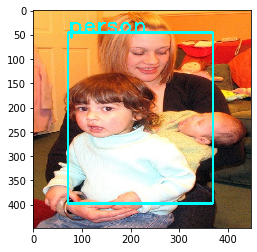

In [121]:
plot_result('/home/pan/dl_py3/pan/comp2/VOCdevkit_test/VOC2007/JPEGImages/000043.jpg')

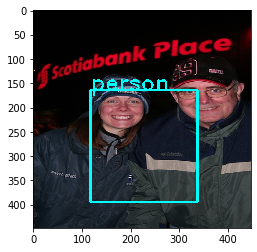

In [123]:
plot_result('/home/pan/dl_py3/pan/comp2/VOCdevkit_test/VOC2007/JPEGImages/000096.jpg')

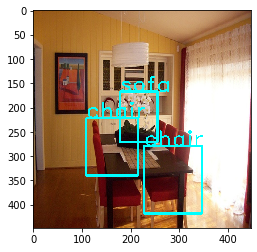

In [124]:
plot_result('/home/pan/dl_py3/pan/comp2/VOCdevkit_test/VOC2007/JPEGImages/000006.jpg')

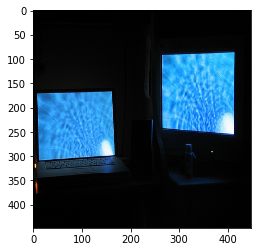

In [126]:
# 這什麼都沒框到 = = 
plot_result('/home/pan/dl_py3/pan/comp2/VOCdevkit_test/VOC2007/JPEGImages/000045.jpg')

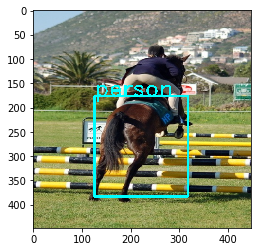

In [127]:
# 豆頁好痛
plot_result('/home/pan/dl_py3/pan/comp2/VOCdevkit_test/VOC2007/JPEGImages/000010.jpg')

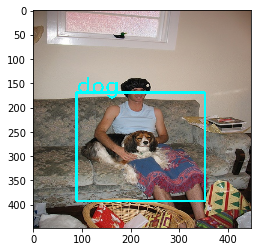

In [128]:
plot_result('/home/pan/dl_py3/pan/comp2/VOCdevkit_test/VOC2007/JPEGImages/000205.jpg')

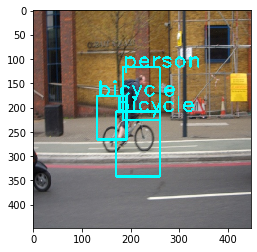

In [129]:
plot_result('/home/pan/dl_py3/pan/comp2/VOCdevkit_test/VOC2007/JPEGImages/000038.jpg')

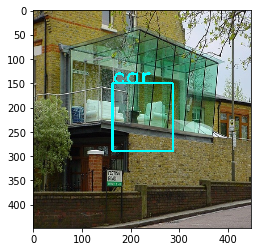

In [130]:
# 物體太小
plot_result('/home/pan/dl_py3/pan/comp2/VOCdevkit_test/VOC2007/JPEGImages/000003.jpg')

* 會導致這個原因有可能是因為下列原因：
1. 對於大物件和小物件計算iou的方式都是相同的，因此一但預測小物件bounding box有一點不同對於iou的影響就會極大，但是大物件的影響就較低。因此小物件的容易產生預測錯位；而較大的物件就影響較小。
2. YOLO每個grid cell只有最多只有2個bounding box和一個類別，也是因為這點所以如果有兩個以上的物件在空間上離的非常近會導致模型無法有效偵測到，因此對於很小的物體會較難辨識。


# Experience

* 這次的比賽使我們了解到資料前處理的重要性，對於挑選不同的pretrain model結合yolo。mAP都會卡在0.6多，很難再往下降，我們認為是因為照片中的物件數量極不平衡與資料量不夠大，大多數物件都是人約略佔了一半的物件數；而其他種類卻只有200~300張。因此模型的準確度沒辦法提升到非常高。對此本組先做平衡物件與augmentation，增加照片數，最後讓物件種類達到平衡，之後再將資料拿去訓練出我們最後的yolo模型。

* 本次比賽的實行都要在Tensorflow2.0底下進行，Tensorflow2.0可以讓我們透過gpu加速模型的訓練。這次的比賽也讓本組較了解Tensorflow2.0的寫法。寫tf code會覺得挫折並且難過，因為常常不清楚tf必須要怎麼組織程式碼才能運行。因此學習tenflow2.0也算是這次比賽的收穫。

* 除了YOLO外，我們認為好的模型還有很多，因此不只是單純去做原本YOLO那模型，也有寫出YOLOv2以及看了一些mask rcnn該如何做(工程太大，最後沒能寫出來)，比較可惜的是一開始沒先想清楚寫新模型可能遇到的困難(像YOLOv2在ImageNet上要重train)，投入過多時間在寫新模型上，但最後出來的成效不是很好，原本的模型可能就沒那麼多時間做到最好，不過好處是可以學到不同想法，以及對tensorflow了解更多，說不定還能為之後比賽提供新想法，尤其是看著別人寫的mask rcnn時，別人code整理的非常易讀，從中也學習到蠻多。雖然對這次沒賽沒有任何幫助，多看較新的模型或code，這肯定對我們的未來會有幫助。

